# OCSVM - 4F - Validación por Repetición
# Basado en nº de outliers

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: mayo 2025

---

## Descripción:

Este notebook implementa un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta
- sigma
- beta_rel

**A diferencia de otros notebooks, aquí el proceso se repite múltiples veces (con diferentes semillas aleatorias en los splits) para comprobar la robustez y variabilidad del modelo.** Cada iteración realiza:

1. División de datos (train/val/test)
2. Escalado
3. Búsqueda de hiperparámetros (grid search sobre `nu` y `gamma`)
4. Evaluación sobre validación y prueba
5. Registro de métricas clave (f1-score, número de outliers, matriz de confusión)

Los resultados de cada iteración se almacenan y analizan para estimar la estabilidad del modelo.

---

## Objetivos específicos:

- Evaluar la variabilidad del modelo OCSVM tras `N` repeticiones
- Analizar la dispersión del mejor f1-score entre repeticiones
- Comparar número de anomalías detectadas en cada iteración
- Obtener métricas medias y desviaciones estándar

---

## Entrada de datos:

- `../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt`

## Salida esperada:

- Tabla resumen de métricas por iteración
- Mejor combinación de hiperparámetros promedio
- Exportación de anomalías más recurrentes


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix


In [28]:
# Load dataset
data_path = "../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})
print(df_astro.columns)

df_astro.head()

Index(['E_peak', 'beta', 'sigma', 'beta_Rel', 'class'], dtype='object')


,E_peak,beta,sigma,beta_Rel,class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [29]:
# --- Selección de características ---
features = ['E_peak', 'beta', 'sigma', 'beta_Rel']
target = 'class'

print(f"Features seleccionadas: {features}")
print(f"Columna objetivo: {target}")

# --- Comprobamos valores nulos ---
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Features seleccionadas: ['E_peak', 'beta', 'sigma', 'beta_Rel']
Columna objetivo: class

 Valores faltantes por columna:
E_peak      0
beta        0
sigma       0
beta_Rel    0
class       0
dtype: int64

 Muestra del dataset:


,E_peak,beta,sigma,beta_Rel,class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


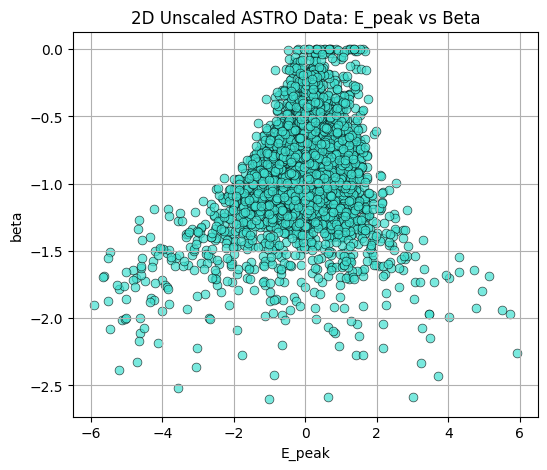

In [30]:
# Representación 2D
plt.figure(figsize=(6, 5))

sns.scatterplot(
    data=df_astro,
    x="E_peak",
    y="beta",
    color="turquoise",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("2D Unscaled ASTRO Data: E_peak vs Beta")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.show()

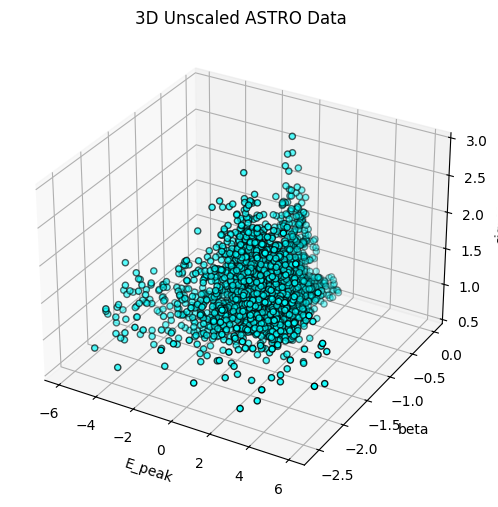

In [31]:
# Representación 3D
x = df_astro['E_peak']
y = df_astro['beta']
z = df_astro['sigma']

labels = df_astro['class']

# Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=labels, cmap='cool', edgecolor='k')

ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('sigma')
plt.title('3D Unscaled ASTRO Data')
plt.show()

In [32]:

# Número de repeticiones
n_iterations = 5

# Guardar resultados de todas las iteraciones
all_iterations_results = []
best_models = []  # opcional: guardar modelo por iteración

print("Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...")
for i in range(n_iterations):
    print(f"\nIteración {i+1}/{n_iterations}")

    # =============== 1️⃣ Split dinámico por iteración ===============
    X = df_astro[features].values
    y = df_astro["class"].values

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=42 + i
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=99 + i
    )

    # =============== 2️⃣ Escalado ===============
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # =============== 3️⃣ Grid search en esta iteración ===============
    nu_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
    gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]

    best_score = 0.0
    iteration_results = []
    best_outliers = np.inf
    best_model_iter = None
    best_params_iter = {}

    for nu in nu_values:
        for gamma in gamma_values:
            model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            model.fit(X_train_scaled)

            preds = model.predict(X_val_scaled)
            pred_labels = np.where(preds == 1, 0, 1)  # 1→normal, -1→outlier
            n_outliers = np.sum(preds == -1)
            true_labels = y_val.astype(int)

            f1 = f1_score(true_labels, pred_labels, pos_label=0)

            iteration_results.append({'nu': nu, 'gamma': gamma, 'val_outliers': n_outliers, 'f1_score': f1})

            """
            if f1 > best_score:
                best_score = f1
                best_model_iter = model
                best_params_iter = {'nu': nu, 'gamma': gamma}
            """
            if n_outliers < best_outliers:
                best_outliers = n_outliers
                best_model_iter = model
                best_params_iter = {'nu': nu, 'gamma': gamma}

    print(f"Mejor iteración {i+1}: nu={best_params_iter['nu']}, gamma={best_params_iter['gamma']}, Outliers (val set): {best_outliers} de {len(X_val_scaled)} muestras, F1={best_score:.4f}")

    # Guardar resultados de esta iteración
    all_iterations_results.extend(
        [dict(iter=i+1, **res) for res in iteration_results]
    )

    best_models.append(best_model_iter)  # opcional

# Convertimos a DataFrame global
df_all_results = pd.DataFrame(all_iterations_results)

# Mostrar el top global
display(df_all_results.sort_values(by='f1_score', ascending=False))


Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...

Iteración 1/5
Mejor iteración 1: nu=0.001, gamma=0.001, Outliers (val set): 3 de 566 muestras, F1=0.0000

Iteración 2/5
Mejor iteración 2: nu=0.001, gamma=0.001, Outliers (val set): 2 de 566 muestras, F1=0.0000

Iteración 3/5
Mejor iteración 3: nu=0.001, gamma=0.001, Outliers (val set): 0 de 566 muestras, F1=0.0000

Iteración 4/5
Mejor iteración 4: nu=0.001, gamma=0.001, Outliers (val set): 1 de 566 muestras, F1=0.0000

Iteración 5/5
Mejor iteración 5: nu=0.001, gamma=0.001, Outliers (val set): 0 de 566 muestras, F1=0.0000


,iter,nu,gamma,val_outliers,f1_score
86,3,0.001,0.001,0,1.000000
87,3,0.001,0.01,0,1.000000
177,5,0.002,0.001,0,1.000000
170,5,0.001,0.001,0,1.000000
171,5,0.001,0.01,0,1.000000
...,...,...,...,...,...
153,4,0.010,10,398,0.457766
160,4,0.020,10,398,0.457766
139,4,0.002,10,410,0.432133
132,4,0.001,10,417,0.416783


In [33]:
from sklearn.utils.multiclass import unique_labels

# Paso 1: identificar hiperparámetros globales
best_global = df_all_results.sort_values(by='f1_score', ascending=False).iloc[0]
print("Mejor combinación global:")
print(best_global)

# Paso 2: reentrenar con X_train + X_val
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

scaler_final = StandardScaler()
X_final_train_scaled = scaler_final.fit_transform(X_final_train)
X_test_scaled = scaler_final.transform(X_test)

# Paso 3: entrenar modelo final
final_model = OneClassSVM(kernel='rbf', nu=best_global['nu'], gamma=best_global['gamma'])
final_model.fit(X_final_train_scaled)

# Paso 4: evaluar en test
test_preds = final_model.predict(X_test_scaled)
test_labels = np.where(test_preds == 1, 0, 1)

# Paso 5: métricas
print("\nEvaluación en el conjunto de test:")
print(f"Outliers (test set): {np.sum(test_preds == -1)} de {len(X_test_scaled)} muestras")
print(f"F1 Score: {f1_score(y_test, test_labels, pos_label=0):.4f}")
print("\nMatriz de confusión:")
cm = confusion_matrix(y_test, test_labels)
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y_test, test_labels, target_names=unique_labels(y_test, test_labels).astype(str)))

Mejor combinación global:
iter                3
nu              0.001
gamma           0.001
val_outliers        0
f1_score          1.0
Name: 86, dtype: object

Evaluación en el conjunto de test:
Outliers (test set): 0 de 567 muestras
F1 Score: 1.0000

Matriz de confusión:
[[567]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       567

    accuracy                           1.00       567
   macro avg       1.00      1.00      1.00       567
weighted avg       1.00      1.00      1.00       567



/Users/martacaninoromero/DarkMatter_ML_TFG/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [34]:

# Evaluar el modelo en el conjunto de validación
val_preds = final_model.predict(X_val_scaled)
n_val_outliers = np.sum(val_preds == -1)
print(f" Outliers (val set): {n_val_outliers} de {len(X_val_scaled)} muestras")

# Evaluar el modelo en el conjunto de test
# (no se ha visto en el entrenamiento)
test_preds = final_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)
print(f" Outliers (test set): {n_test_outliers} de {len(X_test_scaled)} muestras")

 Outliers (val set): 0 de 566 muestras
 Outliers (test set): 0 de 567 muestras


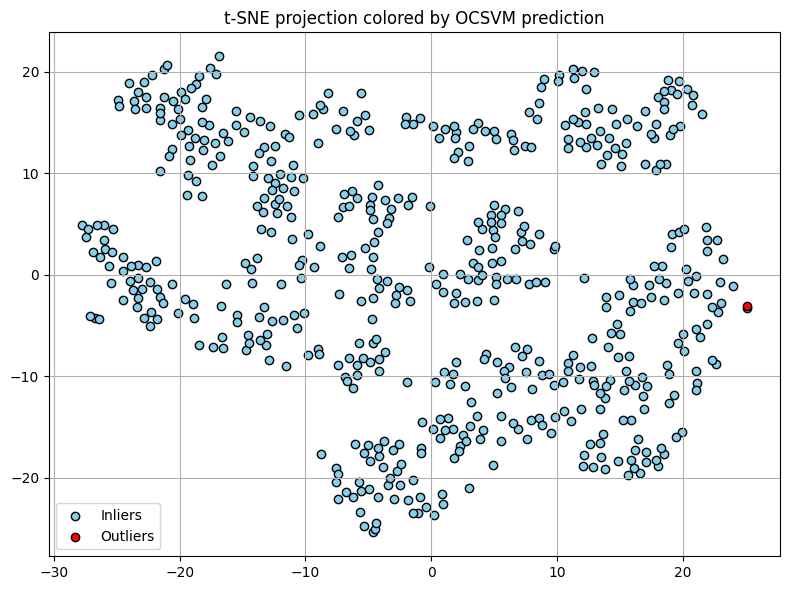

In [35]:
from sklearn.manifold import TSNE

# Fit OCSVM on original high-dim data
ocsvm = OneClassSVM(kernel='rbf', nu=best_global['nu'], gamma=best_global['gamma'])
ocsvm.fit(X_test_scaled)

# Predict outliers
y_pred_ocsvm = ocsvm.predict(X_test_scaled)

# Reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_test_scaled)

# Plot the t-SNE representation, coloring by model prediction
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[y_pred_ocsvm == 1, 0], X_2d[y_pred_ocsvm == 1, 1], c='skyblue', edgecolors='k', label='Inliers')
plt.scatter(X_2d[y_pred_ocsvm == -1, 0], X_2d[y_pred_ocsvm == -1, 1], c='red', edgecolors='k', label='Outliers')
plt.title("t-SNE projection colored by OCSVM prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

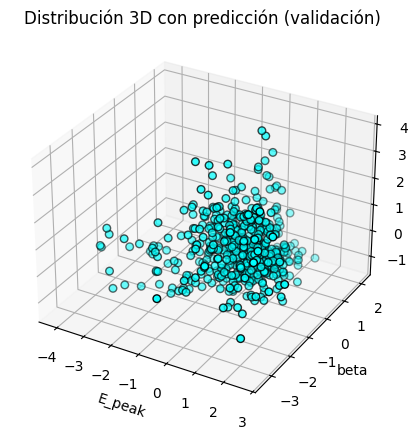

In [36]:
# Visualizamos predicciones en 3D sobre datos de validación
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

X_3d = X_val_scaled

# Predecimos de nuevo sobre validación para la visualización
preds = final_model.predict(X_3d)

ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=preds, cmap='cool', edgecolor='k', s=30)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
plt.title("Distribución 3D con predicción (validación)")
plt.show()

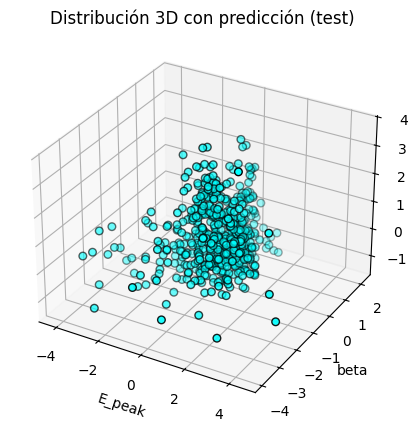

In [37]:
# Visualizamos predicciones en 3D sobre datos de prueba
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

X_3d = X_test_scaled
preds = final_model.predict(X_3d)
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=preds, cmap='cool', edgecolor='k', s=30)

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
plt.title("Distribución 3D con predicción (test)")
plt.show()

# Predict on UNIDs

In [38]:
unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


In [39]:
# convertimos a logaritmo
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"]
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))

In [40]:
# Extraer y escalar
X_unids_log = df_unids_log[["E_peak", "beta", "sigma_det", "beta_Rel"]].values
X_unids_scaled = scaler.transform(X_unids_log)

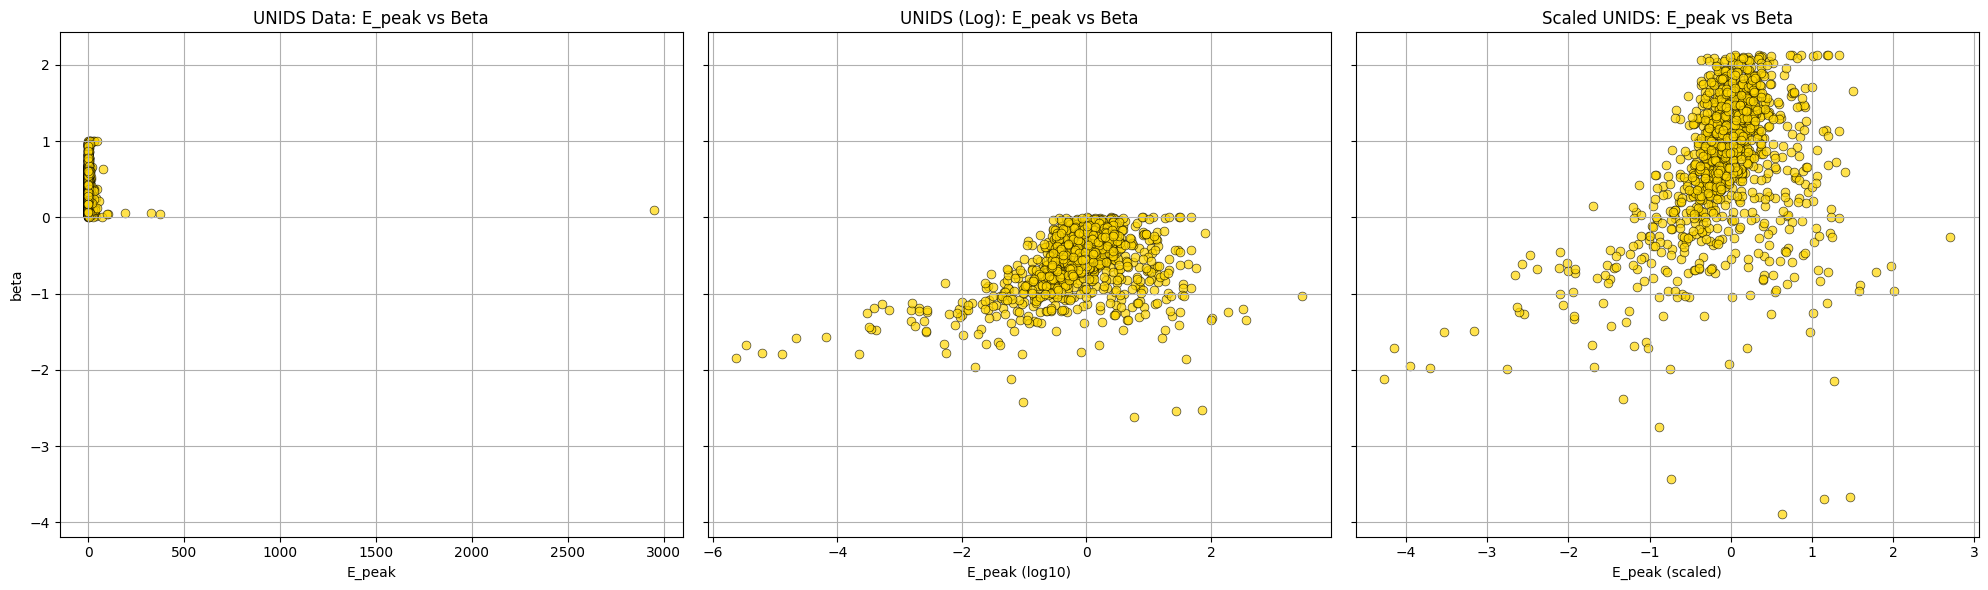

In [41]:
# --- Create subplots ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# --- Plot 1: Raw UNIDS data ---
sns.scatterplot(
    data=df_unids,
    x="E_peak",
    y="beta",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0]
)
axes[0].set_title("UNIDS Data: E_peak vs Beta")
axes[0].set_xlabel("E_peak")
axes[0].set_ylabel("beta")
axes[0].grid(True)

# --- Plot 2: Log-transformed UNIDS ---
sns.scatterplot(
    data=df_unids_log,
    x="E_peak",
    y="beta",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1]
)
axes[1].set_title("UNIDS (Log): E_peak vs Beta")
axes[1].set_xlabel("E_peak (log10)")
axes[1].set_ylabel("")  # hide repeated ylabel
axes[1].grid(True)

# --- Plot 3: Scaled UNIDS ---
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[2]
)
axes[2].set_title("Scaled UNIDS: E_peak vs Beta")
axes[2].set_xlabel("E_peak (scaled)")
axes[2].set_ylabel("")  # hide repeated ylabel
axes[2].grid(True)

plt.tight_layout()
plt.show()


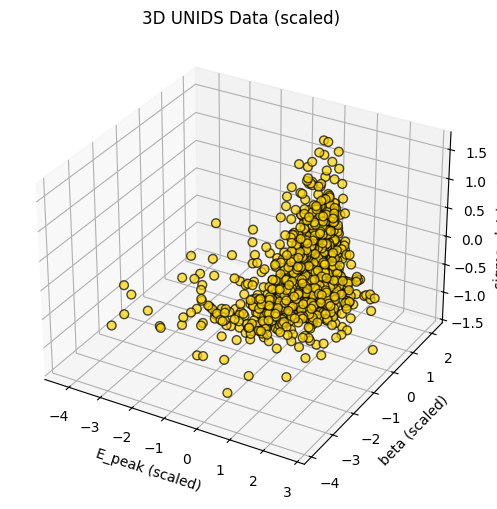

In [42]:
# Visualización de 3D de UNIDS
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_unids_scaled[:, 0], X_unids_scaled[:, 1], X_unids_scaled[:, 2], color="gold", edgecolor='k', alpha=0.7, s=40)
ax.set_xlabel('E_peak (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('sigma_det (scaled)')
plt.title('3D UNIDS Data (scaled)')
plt.show()

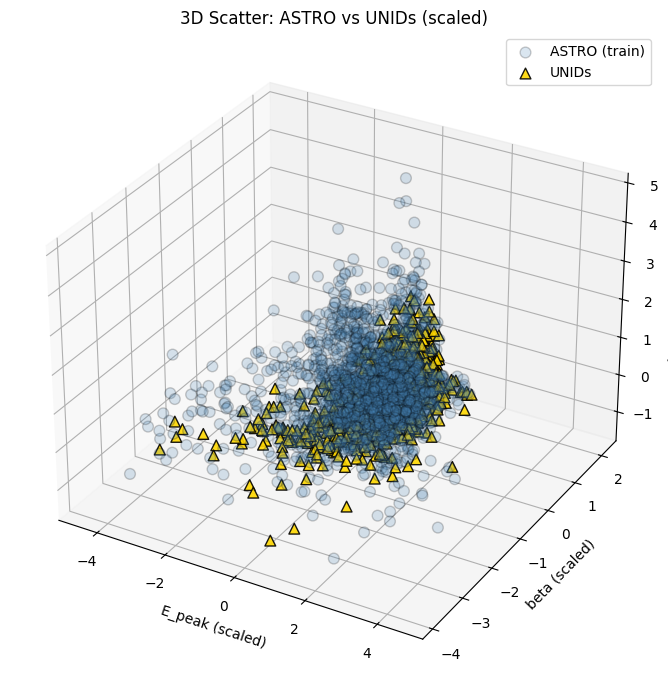

In [43]:
# Scatter de UNIDs vs ASTRO 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter ASTRO (training data)
ax.scatter(
    X_train_scaled[:, 0], X_train_scaled[:, 1], X_train_scaled[:, 2],
    color="steelblue", edgecolor='k', alpha=0.2, s=60, label='ASTRO (train)',
)

# Scatter UNIDs (to predict)
ax.scatter(
    X_unids_scaled[:, 0], X_unids_scaled[:, 1], X_unids_scaled[:, 2],
    color="gold", edgecolor='k', alpha=0.9, s=60, label='UNIDs',
    marker='^'
)

ax.set_xlabel('E_peak (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('sigma_det (scaled)')
ax.set_title('3D Scatter: ASTRO vs UNIDs (scaled)')

ax.legend()
plt.tight_layout()
plt.show()


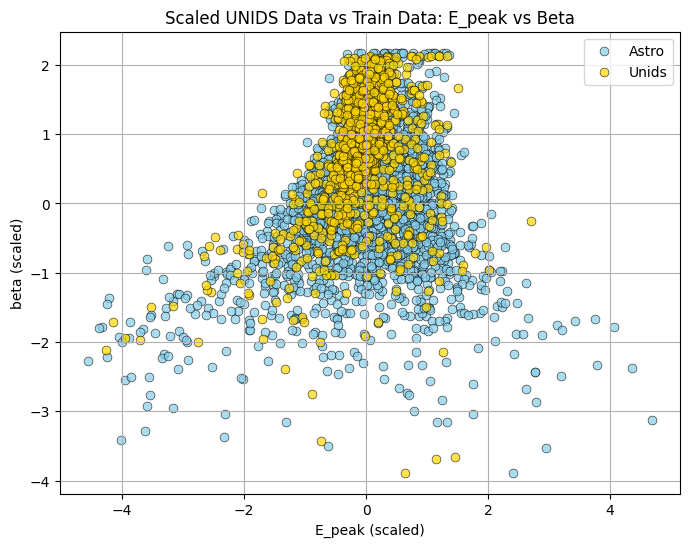

In [44]:
# Scatter de unids escalados vs datos de entrenamiento escalados
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_final_train_scaled[:, 0],
    y=X_final_train_scaled[:, 1],
    color="skyblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='Astro'
)
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40,
    label='Unids'
)
plt.title("Scaled UNIDS Data vs Train Data: E_peak vs Beta")
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Predicciones sobre UNIDS
unids_preds = final_model.predict(X_unids_scaled)

n_unids_outliers = np.sum(unids_preds == -1)
n_unids_normals = np.sum(unids_preds == 1)

print(f" Predicted ASTRO-like: {n_unids_normals}")
print(f" Predicted not ASTRO-like (anomalies): {n_unids_outliers}")
unids_labels = np.where(unids_preds == 1, 0, 1)  # 1 = normal, -1 = outlier → mapeado

 Predicted ASTRO-like: 1124
 Predicted not ASTRO-like (anomalies): 1


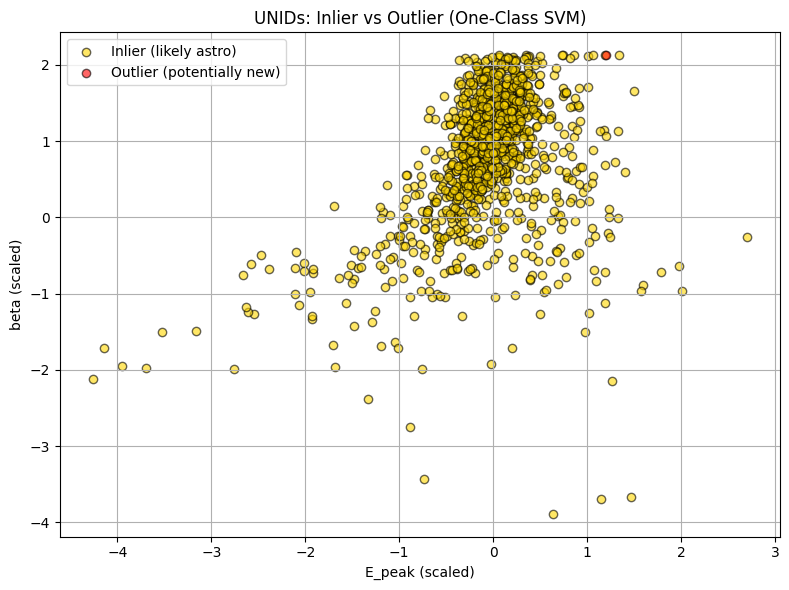

In [46]:
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

plt.figure(figsize=(8, 6))

plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (likely astro)', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (potentially new)', alpha=0.6)

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")

plt.title("UNIDs: Inlier vs Outlier (One-Class SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

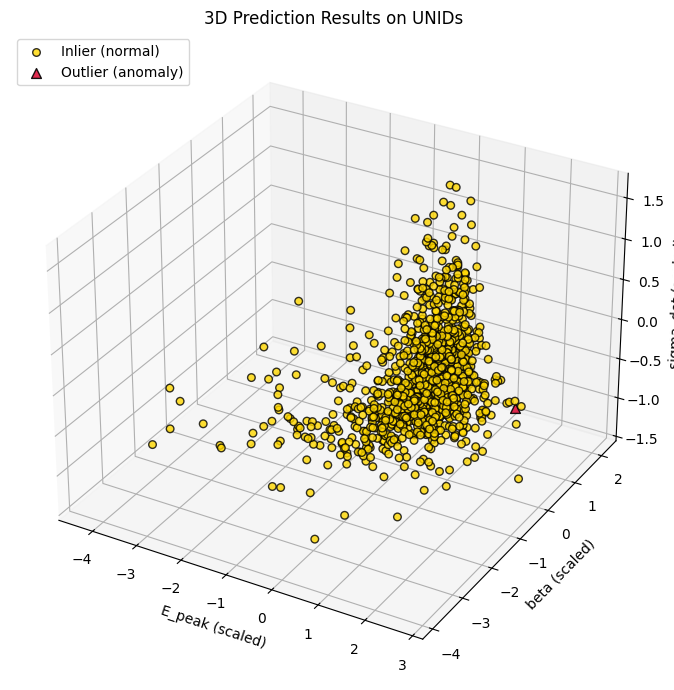

In [47]:
# Visualizamos predicciones en 3D sobre UNIDS

# Get predictions from best model on UNIDs
preds = final_model.predict(X_unids_scaled)  # 1 = inlier, -1 = outlier

# Separate indices
inlier_idx = preds == 1
outlier_idx = preds == -1

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Inliers (normal)
ax.scatter(
    X_unids_scaled[inlier_idx, 0], X_unids_scaled[inlier_idx, 1], X_unids_scaled[inlier_idx, 2],
    c='gold', edgecolor='k', s=30, label='Inlier (normal)', alpha=0.8
)

# Outliers (potential dark matter)
ax.scatter(
    X_unids_scaled[outlier_idx, 0], X_unids_scaled[outlier_idx, 1], X_unids_scaled[outlier_idx, 2],
    c='crimson', marker='^', edgecolor='k', s=50, label='Outlier (anomaly)', alpha=0.9
)

ax.set_xlabel('E_peak (scaled)')
ax.set_ylabel('beta (scaled)')
ax.set_zlabel('sigma_det (scaled)')
ax.set_title("3D Prediction Results on UNIDs")

ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Anomaly Scoring - UNIDs

In [48]:
decision_scores = final_model.decision_function(X_unids_scaled)  # Higher = more normal, lower = more anomalous

unids_preds = final_model.predict(X_unids_scaled)  # 1 = inlier, -1 = outlier

df_unids_log["svm_score"] = decision_scores
df_unids_log["prediction"] = unids_preds

anom_scores = -decision_scores  # Invert: higher = more anomalous
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

df_unids_log["Anomaly_Score"] = anom_scores
df_unids_log["Anomaly_Rank(%)"] = anom_percent

top_anomalies = df_unids_log[df_unids_log["prediction"] == -1].sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)
most_anomalous_idx = top_anomalies.index

top_anomalies.to_csv("../../data/processed/unids_most_anomalous_4F_repeat.txt", sep="\t", index=False)

print("Top Most Anomalous UNID Sources (4F One-Class SVM):")
display(top_anomalies[['number', 'Anomaly_Score', 'Anomaly_Rank(%)']])

Top Most Anomalous UNID Sources (4F One-Class SVM):


,number,Anomaly_Score,Anomaly_Rank(%)
307,307,0.009107,100.0


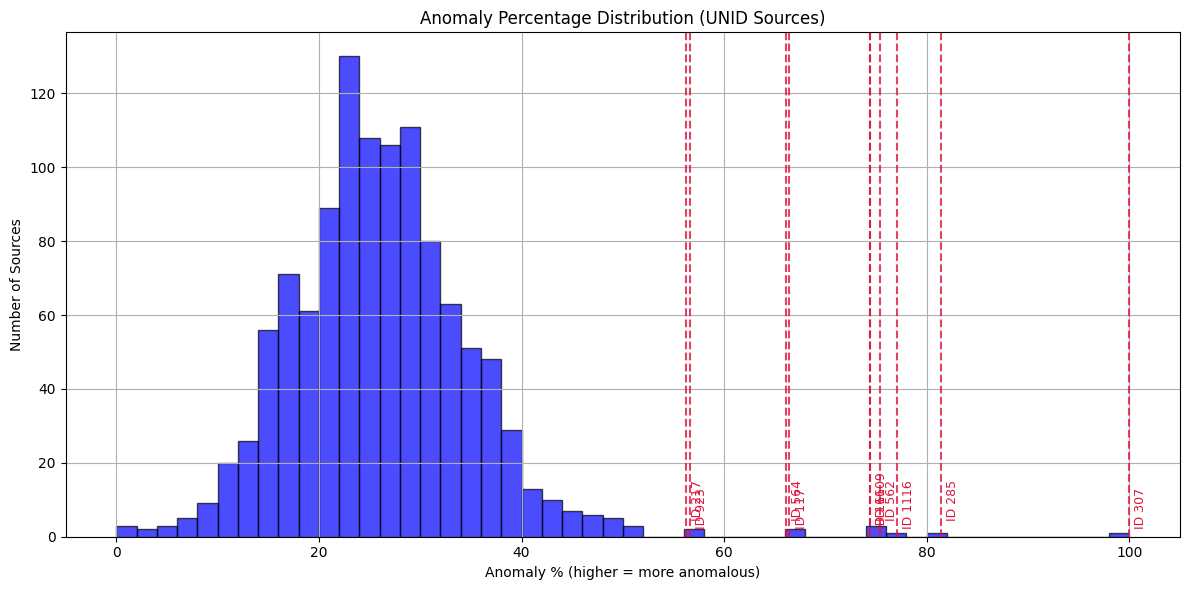

In [49]:
# Sort anomaly scores and grab top N labels
N = 10
sorted_idx = np.argsort(-anom_percent)  # high anomaly % = more anomalous
top_N_idx = sorted_idx[:N]

top_labels = df_unids_log.iloc[top_N_idx]['number'].astype(str).values
top_scores = anom_percent[top_N_idx]

plt.figure(figsize=(12, 6))
plt.hist(anom_percent, bins=50, color='blue', edgecolor='k', alpha=0.7)
plt.title("Anomaly Percentage Distribution (UNID Sources)")
plt.xlabel("Anomaly % (higher = more anomalous)")
plt.ylabel("Number of Sources")

for i in range(N):
    x = top_scores[i]
    label = top_labels[i]
    plt.axvline(x, color='crimson', linestyle='--', alpha=0.8)
    plt.text(x + 0.5, 3 + (i % 2) * 2, f"ID {label}", rotation=90, color='crimson', ha='left', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()


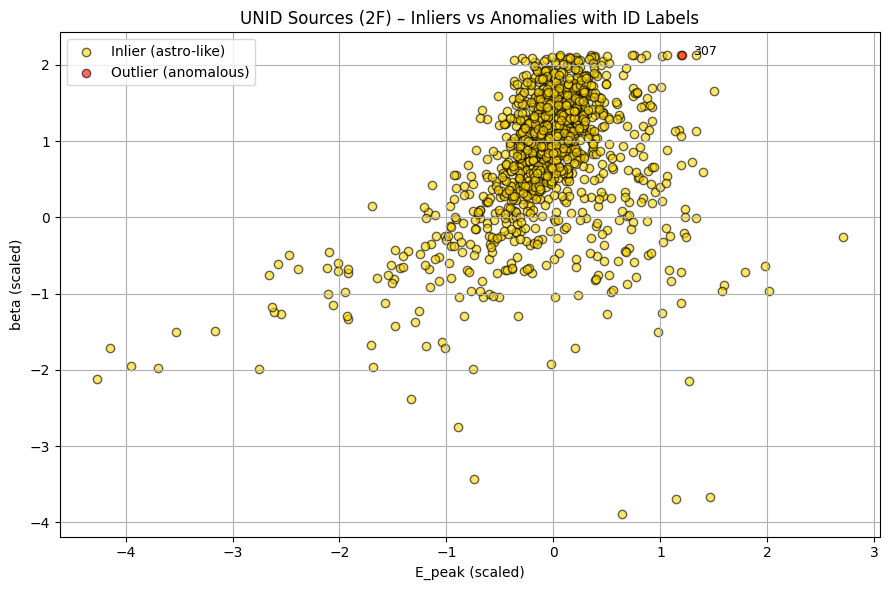

In [50]:
plt.figure(figsize=(9, 6))

# Inliers and outliers from scaled data
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

# Plot inliers (gold)
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (astro-like)', alpha=0.6)

# Plot outliers (red)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (anomalous)', alpha=0.6)

# Annotate top 10 anomalies by ID
for idx in most_anomalous_idx:
    x = X_unids_scaled[idx, 0]  # E_peak (scaled)
    y = X_unids_scaled[idx, 1]  # beta (scaled)
    label = int(df_unids_log.loc[idx, 'number'])
    plt.text(x + 0.1, y, str(label), color='black', fontsize=9)

# Axis labels and styling
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNID Sources (2F) – Inliers vs Anomalies with ID Labels")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("../../outputs/figures/scaled/2F_UNIDs_OneClassSVM_2D_scaled.png", dpi=300, bbox_inches='tight')

plt.show()


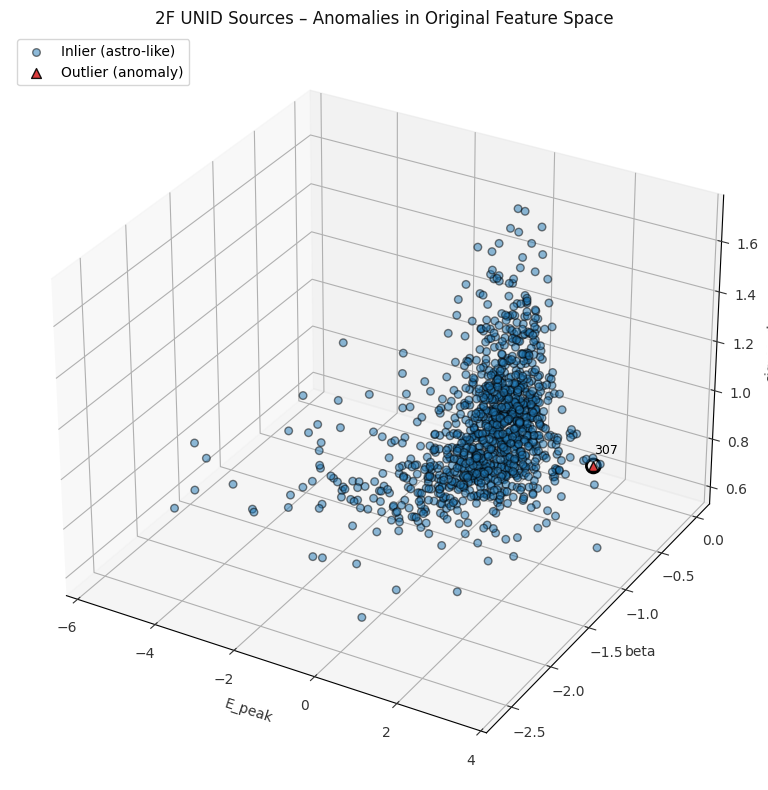

In [51]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Original/log-transformed values for 3 relevant features
x_vals = df_unids_log['E_peak'].values
y_vals = df_unids_log['beta'].values
z_vals = df_unids_log['sigma_det'].values  # or 'beta_Rel' for 3F.2

# Use model predictions for coloring
inlier_idx = df_unids_log['prediction'] == 1
outlier_idx = df_unids_log['prediction'] == -1

# Inliers
ax.scatter(
    x_vals[inlier_idx], y_vals[inlier_idx], z_vals[inlier_idx],
    c='#1f77b4', edgecolor='k', s=30, label='Inlier (astro-like)', alpha=0.5
)

# Outliers
ax.scatter(
    x_vals[outlier_idx], y_vals[outlier_idx], z_vals[outlier_idx],
    c='#d62728', marker='^', edgecolor='k', s=50, label='Outlier (anomaly)', alpha=0.9
)

# Annotate top anomalies
top_anomalies = df_unids_log[df_unids_log['prediction'] == -1].sort_values('Anomaly_Rank(%)', ascending=False).head(10)
for idx in top_anomalies.index:
    ax.scatter(
        x_vals[idx], y_vals[idx], z_vals[idx],
        facecolors='none', edgecolors='black', linewidths=2, s=100
    )
    ax.text(
        x_vals[idx], y_vals[idx], z_vals[idx] + 0.05,
        str(int(df_unids_log.loc[idx, 'number'])),
        color='black', fontsize=9
    )

ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('sigma_det')  # or 'beta_Rel'
ax.set_title("2F UNID Sources – Anomalies in Original Feature Space")
ax.legend(loc='upper left')

ax.tick_params(colors='#333333')
ax.xaxis.label.set_color('#333333')
ax.yaxis.label.set_color('#333333')
ax.zaxis.label.set_color('#333333')
ax.title.set_color('#111111')
ax.grid(color='#aaaaaa', linestyle='--', alpha=0.3)

plt.savefig("../../outputs/figures/2F_UNIDs_OneClassSVM_og.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# Comparar con UNIDs ANN

In [52]:
# Cargar los datos de unIDs (features)
unids_3F = np.genfromtxt('../../data/raw/unids_3F_beta_err_names.txt', dtype='str') 
unids_3F_data = np.asarray(unids_3F[1:, :], dtype=float)
unids_log = np.log10(unids_3F_data[:, [0,1,2,3]])

N_unids = unids_log.shape[0]
N_splits = 5
N_Repeats = 1
N_sample = N_splits * N_Repeats

# Cargar las predicciones ANN 4F
ann_unids_path = "../../ANN_original/unids_DM_std_proba_check_repeated_kfold_rskf_4F_21.txt"
unids_DM_raw = np.genfromtxt(ann_unids_path, dtype='str')[1:]  # quitar cabecera
unids_DM_data = np.asarray(unids_DM_raw, dtype=float)

# Reconstruir matriz (N_unids, N_sample)
unids_number = unids_DM_data[:N_unids, 0]  # índice de los unIDs
prob_matrix = np.reshape(unids_DM_data[:, 1], (N_unids, N_sample))

# Calcular media y desviación estándar por unID
unids_mean = prob_matrix.mean(axis=1)
unids_std = prob_matrix.std(axis=1, ddof=1)

In [53]:
# Crear DataFrame con resultados ANN
df_ann = pd.DataFrame({
    'unid_idx': unids_number.astype(int),
    'ann_mean_prob': unids_mean,
    'ann_std_prob': unids_std
})

df_ann.head()

,unid_idx,ann_mean_prob,ann_std_prob
0,0,0.318913,0.268862
1,1,0.035178,0.075001
2,2,0.106853,0.165058
3,3,0.067615,0.092273
4,4,0.236240,0.323552


In [54]:
# Asegurar coincidencia de identificadores
df_unids_log['unid_idx'] = df_unids_log['number'].astype(int)

# Unir con resultados de OCSVM
df_combined = pd.merge(df_unids_log, df_ann, on="unid_idx", how="inner")

df_combined.head()

,E_peak,beta,sigma_det,beta_Rel,number,svm_score,prediction,Anomaly_Score,Anomaly_Rank(%),unid_idx,ann_mean_prob,ann_std_prob
0,0.400175,-1.047208,0.869208,0.212452,0,0.067300,1,-0.067300,20.455061,0,0.318913,0.268862
1,0.169733,-0.380594,0.733598,-0.113037,1,0.056045,1,-0.056045,32.172242,1,0.035178,0.075001
2,0.203142,-0.168578,1.033058,-0.430366,2,0.059893,1,-0.059893,28.166474,2,0.106853,0.165058
3,-0.031074,-0.557363,0.881133,-0.201588,3,0.065447,1,-0.065447,22.384126,3,0.067615,0.092273
4,-0.351835,-0.493901,0.630916,-0.246028,4,0.057548,1,-0.057548,30.607741,4,0.236240,0.323552


In [55]:
# === 8. Análisis de solapamiento
print("Total unIDs ann:", len(df_ann))
print("Total unIDs ocsvm:", len(df_unids_log))
print("High ANN prob (≥0.9):", (df_ann['ann_mean_prob'] >= 0.9).sum())
print("High ANN prob (≥0.7):", (df_ann['ann_mean_prob'] >= 0.7).sum())
print("High ANN prob (≥0.5):", (df_ann['ann_mean_prob'] >= 0.5).sum())
print("Predicted anomalies (OCSVM):", (df_unids_log['prediction'] == -1).sum())
print("Anomaly rank ≥95%:", (df_unids_log['Anomaly_Rank(%)'] >= 95).sum())

Total unIDs ann: 1125
Total unIDs ocsvm: 1125
High ANN prob (≥0.9): 0
High ANN prob (≥0.7): 4
High ANN prob (≥0.5): 39
Predicted anomalies (OCSVM): 1
Anomaly rank ≥95%: 1


In [56]:
# === 9. Extraer unIDs destacados por ambos modelos
p_cut = 0.4
anom_cut = 40

top_candidates = df_combined[
    (df_combined["ann_mean_prob"] >= p_cut) &
    (df_combined["Anomaly_Rank(%)"] >= anom_cut)
].sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)

print("Top UNIDs by ANN and OCSVM agreement:")
display(top_candidates[["unid_idx", "E_peak", "beta", "ann_mean_prob", "Anomaly_Rank(%)", "Anomaly_Score"]])

Top UNIDs by ANN and OCSVM agreement:


,unid_idx,E_peak,beta,ann_mean_prob,Anomaly_Rank(%),Anomaly_Score
1017,1017,1.682984,-0.000087,0.409883,50.399054,-0.038537
161,161,-4.663220,-1.581699,0.411086,49.041023,-0.039842
843,843,-0.108619,-0.279097,0.554976,47.647424,-0.041180
1009,1009,-0.414686,-0.211832,0.403605,45.742416,-0.043010
1054,1054,3.469896,-1.037631,0.417383,45.660394,-0.043089
861,861,0.589335,-0.006740,0.406786,44.407346,-0.044293
1093,1093,0.959347,-0.212681,0.463604,42.762274,-0.045873
642,642,0.477657,-0.117305,0.437595,42.761406,-0.045874
95,95,1.595981,-1.863279,0.435485,42.588914,-0.046039
254,254,-0.871407,-0.362610,0.544385,42.449075,-0.046174


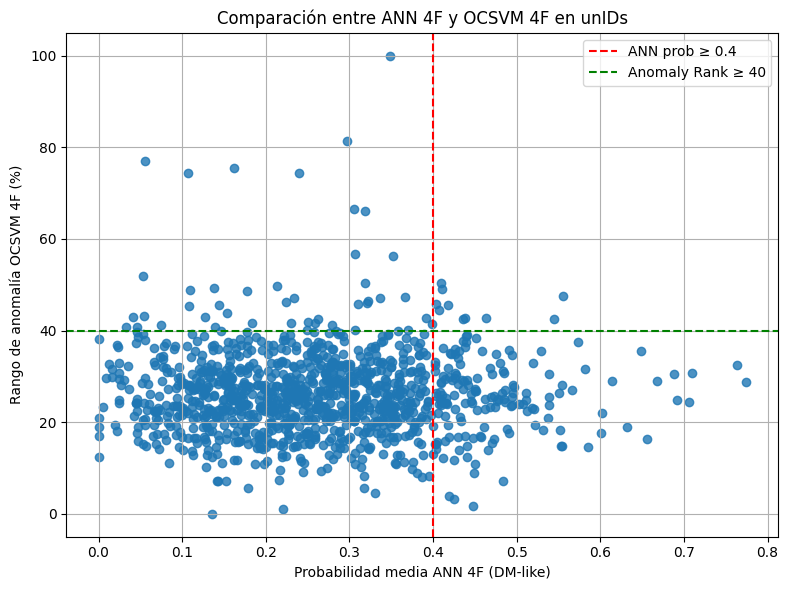

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(df_combined["ann_mean_prob"], df_combined["Anomaly_Rank(%)"], alpha=0.8)
plt.axvline(p_cut, color='red', linestyle='--', label=f'ANN prob ≥ {p_cut}')
plt.axhline(anom_cut, color='green', linestyle='--', label=f'Anomaly Rank ≥ {anom_cut}')
plt.xlabel("Probabilidad media ANN 4F (DM-like)")
plt.ylabel("Rango de anomalía OCSVM 4F (%)")
plt.title("Comparación entre ANN 4F y OCSVM 4F en unIDs")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig("comparacion_ann4f_ocsvm4f.png", dpi=300)
plt.show()